## Final Project - DSE 200X

## Sentiment Analysis of the ECO Hotel

### Can you choose method of sentiment analysis applying to a hotel reviews dataset. Remember that the solution choosen could be incorparated into a business solution.

***Analysis of the Eco-hotel Data Set available from https://archive.ics.uci.edu/ml/datasets/Eco-hotel ***

*** I have choosen ___Vader___ for the sentiment analysis - http://www.nltk.org/_modules/nltk/sentiment/vader.html ***

The dataset has been checked for hyper links. The leading and trailing spaces will be removed at run time as this is what will actually happen in a production application, as would be the case for hyper links. We will not remove emoticons, as this can be handled by Vader.

In [1]:
import codecs
import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections as ct
import json
import csv
import sys  
# https://stackoverflow.com/questions/21129020/how-to-fix-unicodedecodeerror-ascii-codec-cant-decode-byte
reload(sys)  
sys.setdefaultencoding('utf8') # don't do this as it will break the ability to use 'print'. they say that utf8 is 
# default for py 3. I'll assuming that they mean, providing that use py3 and you've got no py2.7 libs or anything else,
# then it works. I don't have that at this moment.
%matplotlib inline

In [2]:
#nltk.download()

In [3]:
hotelComments = pd.read_csv('dataset-CalheirosMoroRita-2017.csv', header=0, delimiter="\n", quoting=3, encoding = 'utf8')
hotelComments.shape

(645, 1)

more that the 401 reviews as stated from the web site

### Cleansing here and also before we analyse and store to file, will remove blank lines and spaces

In [4]:
hotelComments.isnull().any()

Review    False
dtype: bool

In [5]:
raw_words = hotelComments.loc[0,'Review']
raw_words

u' Everything from the weather, staff, food, property, fire pits, d\xe9cor, spa, rooms and beach were top notch'

This shouldn't be a problem for Vader. What we must do is improve the performance
https://stackoverflow.com/questions/45296897/is-there-a-way-to-improve-performance-of-nltk-sentiment-vader-sentiment-analyser

In [6]:
raw_words = hotelComments.loc[1,'Review']
raw_words

u'"The hotel it is fantastic built by the sea, living together with nature. Environment it is great as well as people and service.'

We only need to tokenize each record from the file. Tokenize is either at paragraph level, or sentence. I've choosen for paragraph tokenisation, which will return a list of tokenised sentences. When a single sentence is passed, it still will tokenize it, return only a single list. This is useful since when I use Vader, I will only use the 'compound' value returned for each sentence. See link https://stackoverflow.com/questions/40325980/how-is-the-vader-compound-polarity-score-calculated-in-python-nltk for more info on compound score calculations

We can be sure that not all records read will be a single sentence. According to the Vader documentation, you can get the sentiment for a paragraph on the following way https://github.com/cjhutto/vaderSentiment/blob/master/vaderSentiment/vaderSentiment.py#L517

In [7]:
# this example is from the documentation and is used for initial data analysing 
def compoundSentimentFor(paragraph):
    print("  -- For example, given the following paragraph text from :\n\t'{}'".format(paragraph))
    print("  -- The average the results for the paragraph like this: \n")
    # simple example to tokenize paragraph into sentences for VADER

    analyzer = SentimentIntensityAnalyzer()
    sentence_list = tokenize.sent_tokenize(paragraph)
    paragraphSentiments=0.0
    for sentence in sentence_list:
        vs = analyzer.polarity_scores(sentence)
        print "Polarity scores: ",
        for k in sorted(vs):
            print('{0}: {1} '.format(k, vs[k])),
            print
#        print("{:-<69} {}".format(sentence, str(vs["compound"])))
        paragraphSentiments += vs["compound"]

    print()
    print("AVERAGE SENTIMENT FOR PARAGRAPH: \t" + str(round(paragraphSentiments/len(sentence_list), 4)))
    print("----------------------------------------------------")
    return round(paragraphSentiments/len(sentence_list), 4)

* ***positive sentiment: compound score >= 0.5***
* ***neutral sentiment: (compound score > -0.5) and (compound score < 0.5) ***
* ***negative sentiment: compound score <= -0.5***

How well does the data we have make sense when we run random selections through __Vader__

In [8]:
compoundSentimentFor(hotelComments.loc[0,'Review'])

-0.1531

In [9]:
compoundSentimentFor("I think that Vader is the worst analysis tool ever. That doesn't mean their are better ones out there")

-0.0922

** -0.0922, thats not good. The example above, shows an issue with the result. Neutral for both sentences, I think that we need to concluded that it may not always be possible to get a true sentiment in this case. Even though, it can be seen that a level of negative sentiment is present for the first sentence. **

In [10]:
raw_words = hotelComments.loc[200,'Review']
raw_words

u'It wasn\'t a weekend nice meal, and always mark the experience we had. Given the hotel operation level, I do not think such situations are acceptable.     "'

In [11]:
compoundSentimentFor(hotelComments.loc[200,'Review'])

-0.0035

Now that above is an odd ball, we'll check it again later

In [12]:
compoundSentimentFor(hotelComments.loc[7,'Review'])

0.0

Interesting. Is the above sentence sentiment correct? We'll see later

In [13]:
compoundSentimentFor("Thank you for a wonderful stay!'Very sad to be going home!")

0.0938

Just to be sure that Vader is working properly

In [14]:
compoundSentimentFor("I do not think such situations are acceptable.")

0.3182

In [15]:
compoundSentimentFor("It wasn't a nice meal")

-0.3252

* three examples above are neutral? Not to sure about the last one
* ***neutral sentiment: (compound score > -0.5) and (compound score < 0.5) ***

how about a negative sentence

In [16]:
compoundSentimentFor("I think that Vader is the worst analysis tool ever")

-0.6249

* ***negative sentiment: compound score <= -0.5***

Lets see if we cannot fix a few issues
* ** wrong value for a paragraph were we can see that the sentence contains a negative sentence **
* ** do we really have a neutral sentence?**

First we need a few new functions

In [17]:
# returns the most negative value providing there is a value less than zero
# we use zero as our dividing line between positive and negative sentiment
def senti(sen):
    sentment = 0
    if sen.min() < 0:
        sentment = sen.min()
    else:
        sentment = sen.max()
    
    return sentment

In [18]:
# final sentiment analysis code
# the average is removed and in place we will use the 'senti' function from above

def compoundSentiment(paragraph):
    analyzer = SentimentIntensityAnalyzer()
    sentence_list = tokenize.sent_tokenize(paragraph)
    paragraphSentiments=0.0
    i = 0
    cmps = np.zeros([len(sentence_list)])
    for sentence in sentence_list:
        vs = analyzer.polarity_scores(sentence.strip(" "))
        paragraphSentiments += vs["compound"]
        cmps[i] = vs["compound"]
        i =+1
        
    negative_sentiment = 0
    if len(sentence_list) == 1: 
        negative_sentiment = round(paragraphSentiments, 4)
    else:
        negative_sentiment = round(senti(cmps), 4)
        
    return (negative_sentiment, sentence_list, vs, cmps)

__ Notice that the averaging has been removed and we are now using an array to store the compound results. Which we then derive the correct value for that paragraph and it works well with a single sentence too __

Now we test the single sentence and paragraph with a negative sentence

In [19]:
compoundSentiment("That doesn't mean their are better ones out there")

(0.4404,
 ["That doesn't mean their are better ones out there"],
 {'compound': 0.4404, 'neg': 0.0, 'neu': 0.734, 'pos': 0.266},
 array([ 0.4404]))

In [20]:
compoundSentiment("I think that Vader is the worst analysis tool ever. That doesn't mean their are better ones out there")

(-0.6249,
 ['I think that Vader is the worst analysis tool ever.',
  "That doesn't mean their are better ones out there"],
 {'compound': 0.4404, 'neg': 0.0, 'neu': 0.734, 'pos': 0.266},
 array([-0.6249,  0.4404]))

** The above is much better, it returns the negative sentiment unlike previously were we got '__-0.0922__' **

In [21]:
compoundSentiment(hotelComments.loc[7,'Review'])

(0.0,
 [u'Breakfast has high-quality products, but it lacks in choice.'],
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 array([ 0.]))

So, is the above a neutral sentence which we had seen previously? Looks like it.

In [22]:
compoundSentiment(hotelComments.loc[200,'Review'])

(-0.3252,
 [u"It wasn't a weekend nice meal, and always mark the experience we had.",
  u'Given the hotel operation level, I do not think such situations are acceptable.     "'],
 {'compound': 0.3182, 'neg': 0.0, 'neu': 0.827, 'pos': 0.173},
 array([-0.3252,  0.3182]))

Better that the previous attempt, looks like will need to evaluate the definition of where our classification for neutral and negative sentiment value starts. Given that the compound value is __ -0.3252 __ and we definitely have a negative sentence.
* ***neutral sentiment: (compound score > -0.5) and (compound score < 0.5) ***
* ***negative sentiment: compound score <= -0.5***

In [23]:
tricky_sentences = ["Sentiment analysis has never been good.",
                        "Sentiment analysis has never been this good!",
                        "Most automated sentiment analysis tools are shit.",
                        "With VADER, sentiment analysis is the shit!",
                        "Other sentiment analysis tools can be quite bad.",
                        "On the other hand, VADER is quite bad ass!",
                        "Roger Dodger is one of the most compelling variations on this theme.",
                        "Roger Dodger is one of the least compelling variations on this theme.",
                        "Roger Dodger is at least compelling as a variation on the theme."
                        ]
compoundSentiment("Other sentiment analysis tools can be quite bad.")

(-0.5849,
 ['Other sentiment analysis tools can be quite bad.'],
 {'compound': -0.5849, 'neg': 0.351, 'neu': 0.649, 'pos': 0.0},
 array([-0.5849]))

* **quick test to see if we are on the write track **
* ** The final part of our data cleansing **

In [24]:
# trim any leading or trailing spaces
for row in hotelComments['Review']:
    para = row.strip()
    if len(para) > 3:
        try:
            compoundSentiment(row)
        except:
            print "This is an error message!"

In [25]:
ave_comp, sent_list, ps, vvv = compoundSentiment("Pricing is utterly ridiculous, for what you get.'")

In [26]:
ave_comp, sent_list, ps, vvv

(-0.4201,
 ["Pricing is utterly ridiculous, for what you get.'"],
 {'compound': -0.4201, 'neg': 0.285, 'neu': 0.715, 'pos': 0.0},
 array([-0.4201]))

Now; write out a file the stats for each record. Will write out only the compound values first. I'll do this so that it will make working on the visualisation easier. Also I can compare any changes by diff of files as well as seen the differences visually.

In [27]:

with open('compoundata.csv', 'w') as csvfile:

    mywriter = csv.writer(csvfile, delimiter="\n", quotechar=',', quoting=csv.QUOTE_MINIMAL)    
#    mywriter.writerow(['compound', 'review', 'polarity_scores'])
    mywriter.writerow(['compound'])
    for row in hotelComments['Review']:

        para = row.strip()

        if len(para) > 3:
            ave_comp, sent_list, ps, allCmps = compoundSentiment(para)
#            comp = compoundSentiment(para)

            mywriter.writerow([ave_comp])
#            mywriter.writerow([ave_comp, sent_list])

Read the stored the sentiments. so now we can visualise the results

In [28]:
hotelCompounds = pd.read_csv('compoundata.csv', header=0, delimiter="\n", quoting=3, encoding = 'utf8')
hotelCompounds.shape

(633, 1)

Originally we had 645, now we are down to 633. Those 12 are those which are blank lines

In [29]:
hotelCompounds.head()

,compound
0,-0.1531
1,0.7351
2,0.5106
3,0.4404
4,-0.3400


In [30]:
type(hotelCompounds)

pandas.core.frame.DataFrame

Now for the printing

In [31]:
colors2 = []
for hc in hotelCompounds['compound']:
    if hc >= 0.5: # positive sentiment
        colors2.append('#02ccfe',)#15b01a
#        print('{0}: {1} '.format(hc, 'green'))

    elif hc <= -0.25: # negative sentiment
        colors2.append('#ff796c',)#ff000d
#        print('{0}: {1} '.format(hc, 'bright red'))

    elif hc <= -0.5: # negative sentiment
        colors2.append('#f97306',)#ff000d
#        print('{0}: {1} '.format(hc, 'bright red'))

    else: # neutral sentiment
        colors2.append('#c5c9c7',)  ##0343df
#        print('{0}: {1} '.format(hc, 'blue'))

Colours sorted for the different sentiment, now the counts (reviews) to help the plot along

In [32]:
revs = np.arange(hotelCompounds.size)

finally the sentiment values, these are the compound values which we've calculated and stored, made it easier for developing the visuals

In [33]:
hCmpds = hotelCompounds['compound'].tolist()

plot it, keep it simple and clean

Looks like a silver line of neutral reviews at 0.0, checked that and those are real results, yes it still looks like a silver line.

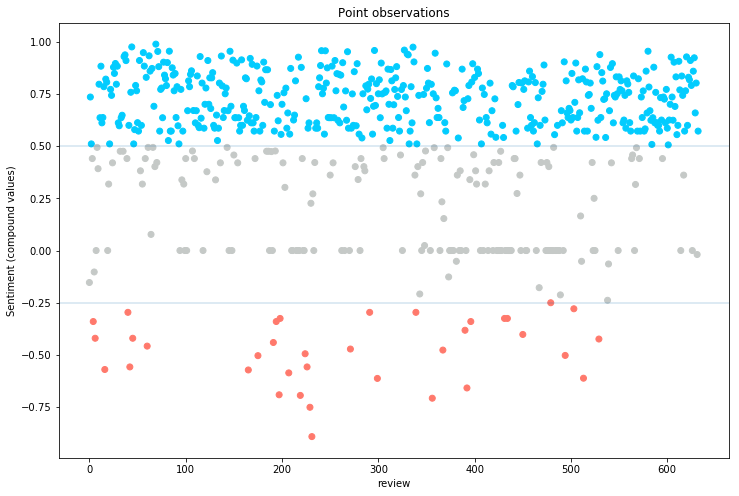

In [34]:

fig = plt.figure(figsize=(12,8))

plt.scatter(revs,hCmpds,c=colors2)

plt.axhline(y=0.5, alpha=0.2)
plt.axhline(y=-0.25, alpha=0.2)
#plt.axhline(y=-0.5, alpha=0.2)
plt.title("Point observations")
plt.xlabel("review")
plt.ylabel("Sentiment (compound values)")

plt.show()


We have a base approach which we can use to drive an application which will notify of any negative sentiment. The reviews would be cleansed prior to analysis. It doesn't need to be a batch based application, just read the data as they sent and follow this with the analysis. Log all results and notify the User with a Web based user interface to interogate any sentiment, doesn't just have to be negative only.